In [1]:
#import the different packages used throughout
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import math
import datetime
import boto3
from os.path import expanduser
import os
import json

%matplotlib inline

In [2]:
#calcuate the distance (in degrees) between 2 points in lat/long
def lat_long_to_arc(lat1,long1,lat2,long2):
    # Convert latitude and longitude to
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0

    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians

    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians

    # Compute spherical distance from spherical coordinates.

    # For two locations in spherical coordinates
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) =
    # sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length

    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) +
    math.cos(phi1)*math.cos(phi2))
    if cos>1: cos=1
    if cos<-1: cos=-1
    arc = math.acos( cos )

    return arc

In [3]:
def find_nearest_box(llat,llon,point):
    D = [lat_long_to_arc(l1,l2,point[0],point[1]) for l1,l2 in zip(llat,llon)]
    return np.argmin(D)
    

In [4]:
def remove_dublicate(Data, Time, labels, month, year):
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    time = pd.DatetimeIndex(Time)
    index = np.argwhere((labels==-1) & (time.month>month))

    Data = np.delete(Data,index,0)
    Time = np.delete(Time,index)
    time = np.delete(time,index)
    labels = np.delete(labels,index)

    for i in range(n_clusters_):
        cluster = Data[labels==i,:]
        tcluster = time[labels==i]
        if month<12:
            if np.amin(np.array(tcluster.month))>month:
                Data = Data[labels!=i,:]
                Time = Time[labels!=i]
                time = time[labels!=i]
                labels = labels[labels!=i]
            elif np.max(tcluster).month>month & np.max(tcluster).day>4:
                Data = Data[labels!=i,:]
                Time = Time[labels!=i]
                time = time[labels!=i]
                labels = labels[labels!=i]
        else:
            if np.amax(np.array(tcluster.month))==1:
                Data = Data[labels!=i,:]
                Time = Time[labels!=i]
                time = time[labels!=i]
                labels = labels[labels!=i]
            elif np.max(tcluster).month==1 & np.max(tcluster).day>4:
                Data = Data[labels!=i,:]
                Time = Time[labels!=i]
                time = time[labels!=i]
                labels = labels[labels!=i]

    return Data, Time, labels

In [13]:
home = expanduser("~")

with open(os.path.join(home,'creds.json')) as creds_file:
    creds_data = json.load(creds_file)

#Access from S3
s3 = boto3.resource('s3',aws_access_key_id=creds_data['key_id'],
         aws_secret_access_key=creds_data['key_access'],region_name='us-west-2')
bucket = s3.Bucket('himatdata')
home = os.getcwd()

for obj in bucket.objects.filter(Delimiter='', Prefix='Trmm/EPO/*Clustered_Data*', ):
    if obj.key[-4:] == ".nc4":
        print(obj.key)

774


Text(0.5,1,'Range of Latent Heat Profiles in Events')

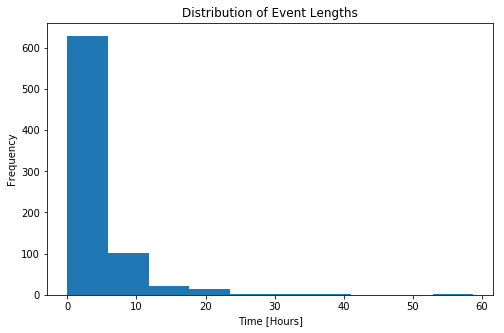

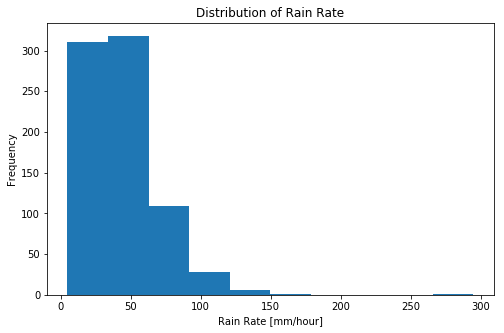

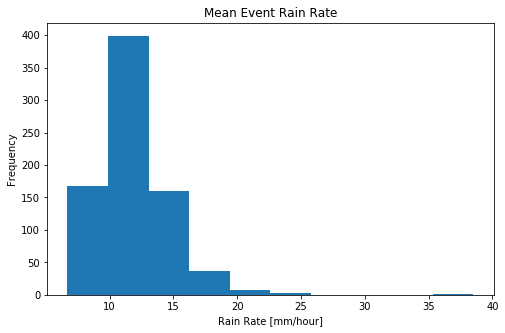

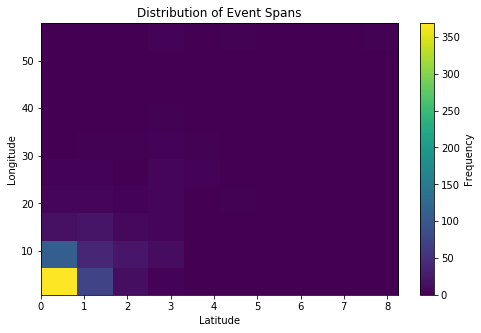

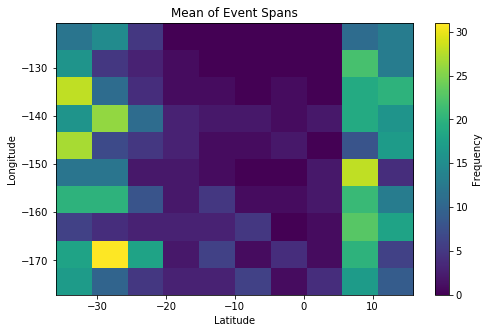

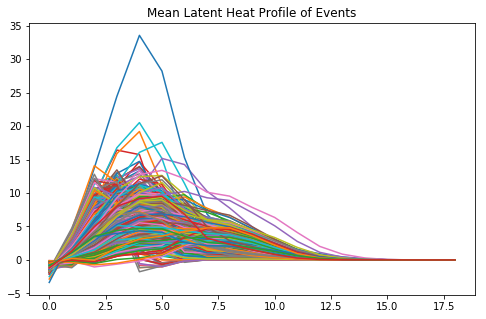

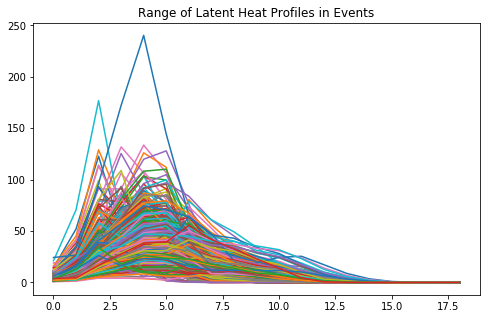

In [27]:
file = xr.open_dataset('/Users/lauren/Downloads/2000_08Clusted_Data.nc4')
Data = file.Data.data #[delta_time, lat, lon, surface_rain, latent heat profile]
labels = file.Labels.data
Time = file.time.data

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)
cluster_spans = np.zeros((len(Data[0,:]),n_clusters_))
cluster_means = np.zeros((len(Data[0,:]),n_clusters_))
for i in range(n_clusters_):
    cluster = Data[labels==i,:]
    cluster_spans[:,i] = np.amax(cluster,axis=0)-np.amin(cluster,axis=0)
    cluster_means[:,i] = np.nanmean(cluster,axis=0)

fig = plt.figure(figsize=(8,5))
plt.hist(cluster_spans[0,:])
plt.title('Distribution of Event Lengths')
plt.xlabel('Time [Hours]')
plt.ylabel('Frequency')

fig = plt.figure(figsize=(8,5))
plt.hist(cluster_spans[3,:])
plt.title('Distribution of Rain Rate')
plt.xlabel('Rain Rate [mm/hour]')
plt.ylabel('Frequency')

fig = plt.figure(figsize=(8,5))
plt.hist(cluster_means[3,:])
plt.title('Mean Event Rain Rate')
plt.xlabel('Rain Rate [mm/hour]')
plt.ylabel('Frequency')


fig = plt.figure(figsize=(8,5))
plt.hist2d(cluster_spans[1,:],cluster_spans[2,:])
plt.title('Distribution of Event Spans')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar().set_label('Frequency')

fig = plt.figure(figsize=(8,5))
plt.hist2d(cluster_means[1,:],cluster_means[2,:])
plt.title('Mean of Event Spans')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar().set_label('Frequency')

fig = plt.figure(figsize=(8,5))
plt.plot(cluster_means[4:,:]);
plt.title('Mean Latent Heat Profile of Events')

fig = plt.figure(figsize=(8,5))
plt.plot(cluster_spans[4:,:]);
plt.title('Range of Latent Heat Profiles in Events')



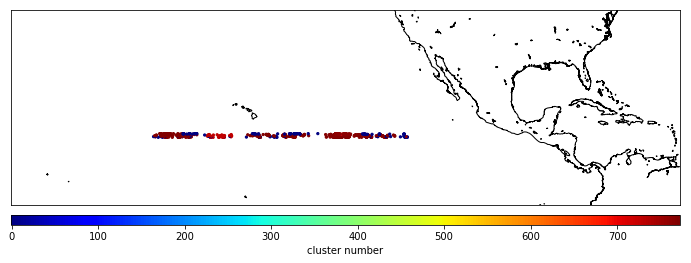

In [109]:
bbox = [0,40,150,300]

plt.figure(figsize=(12,6))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
cmap = plt.get_cmap('gist_earth')

# Draw coastlines
m.drawcoastlines()

time = pd.DatetimeIndex(Time)
#indices = np.argwhere((time<datetime.datetime(2000,8,2)) & (time>datetime.datetime(2000,7,30)) & (labels>-1))
indices = np.argwhere((Data[:,1]>15))

#indices = np.argwhere(labels==709)

llat = Data[indices,1]
llon = Data[indices,2]
clusnum = Data[indices,0]
clusnum = labels[indices]

cs = m.scatter(360+llon,llat, latlon=True, c=clusnum, s=5,cmap='jet')
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('cluster number')


In [84]:
print(np.unique(labels[indices]))

print(6371*lat_long_to_arc(12,np.amin(Data[labels==710,2]),12,np.amin(Data[labels==709,2])))

[701 702 703 704 705 706 707 708 709 710 711 712 713 714 715 716 717 718
 719]
1082.1529694576675


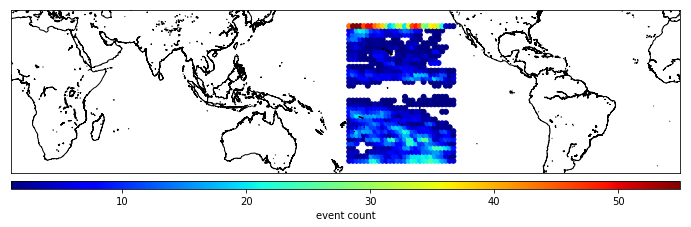

In [25]:
bbox = [-40,40,0,360]

plt.figure(figsize=(12,6))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
cmap = plt.get_cmap('gist_earth')

# Draw coastlines
m.drawcoastlines()

Lat_Boxes = range(-35,35,2)
Lon_Boxes = range(-180,-120,2)

llat, llon = np.meshgrid(Lat_Boxes,Lon_Boxes)
llat = llat.flatten()
llon = llon.flatten()

events_count = np.zeros((len(llat)))

for i in range(n_clusters_):
    cluster = Data[labels==i,:]
    cluster = np.unique(cluster[:,1:3],axis=0)
    incluster = np.zeros(len(llat))
    for j in range(len(cluster)):
        ind_near = find_nearest_box(llat,llon,cluster[j,:])
        incluster[ind_near] = 1
    events_count += incluster


llat = llat[events_count!=0]
llon = llon[events_count!=0]
events_count = events_count[events_count!=0]

cs = m.scatter(llon.flatten(),llat.flatten(), latlon=True, c=events_count.flatten(), s=25,cmap='jet')
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('event count')


Int64Index([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
            5, 5, 5, 5, 5],
           dtype='int64')
Int64Index([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
            14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
            14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
            14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
            14, 14, 14],
           dtype='int64')
Int64Index([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
            14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
            14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
            14, 14, 14, 14, 14],
           dtype='int64')
Int64Index([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
            14],
           dtype='int64')
Int64Index([18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,

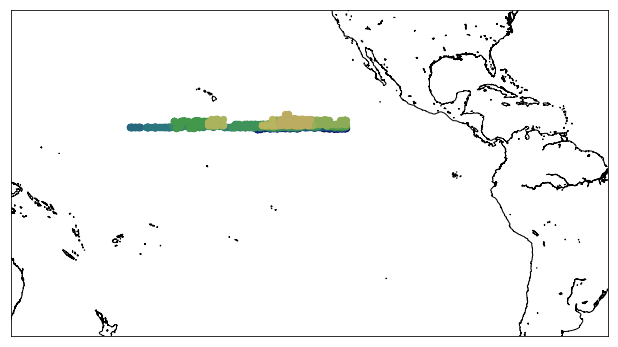

In [94]:
#region overwhich to show the plot
bbox = [-40,40,150,310]

plt.figure(figsize=(12,6))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
cmap = plt.get_cmap('gist_earth')

# Draw coastlines and fill continents and water with color
m.drawcoastlines()

#look at the clusters within the range labels_min to labels_max
labels_min = np.min(labels)+700
labels_max = 720

#plot the location of rain for the individual clusters (colored by cluster)
for ii in range(labels_min,labels_max):
    print(time[labels==ii].day)
    cluster = Data[labels==ii,:]
    color_interp = np.interp(ii,[labels_min,labels_max],[0,200])
    m.scatter(cluster[:,2],cluster[:,1],s=40,marker='o',color=cmap(int(color_interp)),latlon=True)

In [110]:
print(int('01'))

1
